# Research on prepaid plans for Megaline
You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans is more profitable in order to adjust the advertising budget.
You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze clients' behavior and determine which prepaid plan is more profitable.

## Import Libraries to prepare for analysis

In [102]:
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import factorial
from scipy import stats as st
from functools import reduce
import math

## Step 1. Open the data files and study the general information. 

In [105]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [106]:
calls['duration'].value_counts()

0.00     26834
8.37       102
4.02       102
3.91       101
7.61       100
         ...  
25.53        1
29.34        1
26.05        1
36.24        1
27.16        1
Name: duration, Length: 2802, dtype: int64

In this dataframe I have 4 columns. There is one float, int, and 2 objects. There are no missing values. There were 137735 calls made during this period of the data. 

There are 26834 calls with 0.00 duration. Missed calls? People did not pick up? It doesn't matter towards the data because it is included within the price for surf or Ultimate if its just a call but no duration.



In [107]:
internet = pd.read_csv('/datasets/megaline_internet.csv')
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [108]:
internet['mb_used'].value_counts()

0.00      13747
414.46        8
435.77        8
417.46        7
313.79        7
          ...  
638.12        1
217.39        1
683.90        1
243.97        1
563.11        1
Name: mb_used, Length: 57624, dtype: int64

In this dataframe I have similar to data_calls. 1 float, 1 integer, and 2 objects. 
Actually its similar data from the calls just it is dealing with internet instead of calls. 

There was 104825 usages of internet during this period. 
Can probably merge this with calls to see the user usage in general. 

I will need to calculate mb_used to Gigabyte in order to make sure the data coincides together when we are calculating the usd_per_gb later. 

Seems like some users did not actually use any mb and a lot of this data is less than a gb.

In [109]:
messages = pd.read_csv('/datasets/megaline_messages.csv')
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In this dataframe we have 1 integer and two objects. 

There were 76051 messages sent during this data period. Again I will need to merge the user_id to find the general usage all in one frame.

In [110]:
plans = pd.read_csv('/datasets/megaline_plans.csv')
plans.info()
plans.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


This is important information to have since it gives me the information about how the plans work. 

In [111]:
users = pd.read_csv('/datasets/megaline_users.csv')
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Here we have the users and their information. Will need this later for the city. it also shows what plan they have. I will merge this with the other data to get plan and city

In [112]:
users['churn_date'].value_counts()

2018-12-18    3
2018-12-19    2
2018-12-31    2
2018-11-14    2
2018-11-29    1
2018-12-27    1
2018-09-18    1
2018-07-31    1
2018-11-30    1
2018-09-17    1
2018-10-22    1
2018-10-13    1
2018-12-30    1
2018-09-07    1
2018-11-21    1
2018-12-10    1
2018-08-16    1
2018-12-15    1
2018-12-12    1
2018-11-11    1
2018-09-01    1
2018-11-18    1
2018-12-26    1
2018-12-22    1
2018-11-16    1
2018-10-07    1
2018-11-24    1
2018-10-03    1
2018-08-19    1
Name: churn_date, dtype: int64

In [113]:
users_churn_date_09_18 = users.query('churn_date == "2018-09-18"')
users_churn_date_09_18

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
491,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18


In [114]:
users_1491 = internet.query('user_id == "1491"')
users_1491

,id,user_id,session_date,mb_used
102568,1491_1,1491,2018-06-19,55.74
102569,1491_2,1491,2018-05-05,0.00
102570,1491_3,1491,2018-07-24,0.00
102571,1491_4,1491,2018-09-30,592.52
102572,1491_5,1491,2018-07-11,670.40
...,...,...,...,...
102762,1491_264,1491,2018-07-14,288.56
102763,1491_266,1491,2018-09-11,53.78
102764,1491_267,1491,2018-08-21,692.78
102765,1491_268,1491,2018-12-27,0.00


In [115]:
users_finish = users[users.notnull().all(axis=1)]
users_finish

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12


The 34 users that ended their time with Megaline. I will now see if I can find which of them has services after their time was finished with Megaline. These are errors and I will get rid of those users. But first I will change the months.

### Conclusion

No missing values. The beginning of the year had less amount of use then the end of the year. According to churn_date most of the users are still on their plans because we only have 34 in churn_date meaning only 34 users stopped using the service.

A lot of users did not have any duration of calls and a few also never used data.

### Conclusion based on Review

No missing values necessarily. Churn Date NaN just means that the person continues having the service. The beginning of the year had less amount of use then the end of the year. According to churn_date most of the users are still on their plans because we only have 34 in churn_date meaning only 34 users stopped using the service. 

But when checking one of those users 1491 I noticed that even though they ended their service on 2018-09-18 they were still seeming to be using the service on a few different occasions after the termination. This may mean that the whole system of churn_date may not be helpful for analysis. I will be dropping it later anyway because of its missing values

A lot of users did not have any duration of calls and a few also never used data.

## Step 2 Converting types, Pivot, Merging. Preparing Data for calculations

#### Converting types

In [116]:
calls['call_date'] = pd.to_datetime(calls['call_date'])

In [117]:
calls['month'] = calls['call_date'].dt.month

In [118]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [119]:
users['churn_date'] = pd.to_datetime(users['churn_date'])

In [120]:
internet['month'] = internet['session_date'].dt.month

In [121]:
messages['message_date'] = pd.to_datetime(messages['message_date'])

In [122]:
messages['month'] = messages['message_date'].dt.month

In [123]:
users['churn_date'] = users['churn_date'].dt.month

#### Conclusion

converted the dates that were object type to datetime type so I can pull the month from them.

I also did this for churn_date in users data and will now check which users to drop based on if their end date has any data after they ended the service because this will be an error.

### The number of calls made and minutes used per month

In [124]:
calls_grouped = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ('count', 'sum'))
calls_grouped

count     sum
user_id month               
1000    12        16  116.83
1001    8         27  171.14
        9         49  297.69
        10        65  374.11
        11        64  404.59
...              ...     ...
1498    12        39  324.77
1499    9         41  330.37
        10        53  363.28
        11        45  288.56
        12        65  468.10

[2258 rows x 2 columns]

In [125]:
calls_grouped.columns = ['calls', 'minutes']

#### Conclusion

Made a pivot table to find the number of calls made and the minutes used per month for each user. Then changed the columns of count and sum to calls and minutes.

### The number of text messages sent per month

In [126]:
messages_grouped = messages.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = ('count'))
messages_grouped

id
user_id month    
1000    12     11
1001    8      30
        9      44
        10     53
        11     36
...            ..
1496    9      21
        10     18
        11     13
        12     11
1497    12     50

[1806 rows x 1 columns]

In [127]:
messages_grouped.columns = ['messages']

#### Conclusion

Made a pivot table to get the number of text messages per month per user.
Then changed the column name id to messages.

### The volume of data per month

In [128]:
internet_grouped = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = ('sum'))
internet_grouped

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

#### Conclusion

Made a pivot table to get the volume of data used per month

### Merging internet usage, calls, and messages per month usage to one table

In [129]:
internet_calls = pd.merge( left = internet_grouped, right = calls_grouped, how ='outer', on=['user_id', 'month']).fillna(0)

usage_per_month =pd.merge( left = internet_calls, right = messages_grouped, how='outer', on=['user_id', 'month']).fillna(0).reset_index()
usage_per_month

,user_id,month,mb_used,calls,minutes,messages
0,1000,12,1901.47,16.0,116.83,11.0
1,1001,8,6919.15,27.0,171.14,30.0
2,1001,9,13314.82,49.0,297.69,44.0
3,1001,10,22330.49,65.0,374.11,53.0
4,1001,11,18504.30,64.0,404.59,36.0
...,...,...,...,...,...,...
2288,1470,11,0.00,81.0,602.30,156.0
2289,1470,12,0.00,78.0,560.44,153.0
2290,1484,11,0.00,2.0,37.50,1.0
2291,1491,4,0.00,8.0,40.45,6.0


In [130]:
usage_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 6 columns):
user_id     2293 non-null int64
month       2293 non-null int64
mb_used     2293 non-null float64
calls       2293 non-null float64
minutes     2293 non-null float64
messages    2293 non-null float64
dtypes: float64(4), int64(2)
memory usage: 107.6 KB


#### Conclusion

Merged the tables with all the calculations. Some users didn't really take adavantage of the plan it seems and User 1001 has been very active

In [131]:
users_plans = users[['user_id','tariff']]
users_plans.columns = ['user_id','plan_name']

In [132]:
users_plans1 = pd.merge(left=users_plans,right= plans,how='outer',on='plan_name')

In [133]:
users_plans2 = pd.merge(left=users_plans1, right = users, how='outer', on='user_id')
users_plans2

,user_id,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,ultimate,1000,30720,3000,70,7,0.01,0.01,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1006,ultimate,1000,30720,3000,70,7,0.01,0.01,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,12.0
2,1008,ultimate,1000,30720,3000,70,7,0.01,0.01,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
3,1011,ultimate,1000,30720,3000,70,7,0.01,0.01,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN
4,1013,ultimate,1000,30720,3000,70,7,0.01,0.01,Nicolas,Snider,50,"Knoxville, TN MSA",2018-12-01,ultimate,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1494,surf,50,15360,500,20,10,0.03,0.03,Preston,Downs,70,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-19,surf,NaN
496,1495,surf,50,15360,500,20,10,0.03,0.03,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
497,1496,surf,50,15360,500,20,10,0.03,0.03,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
498,1498,surf,50,15360,500,20,10,0.03,0.03,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


In [134]:
data_for_profit = pd.merge(left=usage_per_month , right= users_plans2, how='outer',on='user_id')
data_for_profit

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,usd_per_gb,usd_per_message,usd_per_minute,first_name,last_name,age,city,reg_date,tariff,churn_date
0,1000,12.0,1901.47,16.0,116.83,11.0,ultimate,1000,30720,3000,...,7,0.01,0.01,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,8.0,6919.15,27.0,171.14,30.0,surf,50,15360,500,...,10,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1001,9.0,13314.82,49.0,297.69,44.0,surf,50,15360,500,...,10,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
3,1001,10.0,22330.49,65.0,374.11,53.0,surf,50,15360,500,...,10,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
4,1001,11.0,18504.30,64.0,404.59,36.0,surf,50,15360,500,...,10,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2298,1143,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,...,10,0.03,0.03,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,NaN
2299,1307,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,...,10,0.03,0.03,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,NaN
2300,1319,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,...,10,0.03,0.03,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,NaN
2301,1378,NaN,NaN,NaN,NaN,NaN,surf,50,15360,500,...,10,0.03,0.03,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,NaN


In [135]:
data_for_profit['mb_used'] = np.ceil(data_for_profit['mb_used'])
data_for_profit['minutes'] = np.ceil(data_for_profit['minutes'])

In [136]:
data_for_profit['internet'] = data_for_profit['mb_used']

In [137]:
data_for_profit.isna().sum()

user_id                     0
month                      10
mb_used                    10
calls                      10
minutes                    10
messages                   10
plan_name                   0
messages_included           0
mb_per_month_included       0
minutes_included            0
usd_monthly_pay             0
usd_per_gb                  0
usd_per_message             0
usd_per_minute              0
first_name                  0
last_name                   0
age                         0
city                        0
reg_date                    0
tariff                      0
churn_date               2143
internet                   10
dtype: int64

### Will now work on dropping the users from users that finished their plans but still had data for them. I will also drop the 10 other users from the data because they had no data in the datasets to begin with and that is why they have come up NaN

In [138]:
data_for_profit.dropna(subset = ['month','mb_used','calls', 'minutes', 'messages'], inplace = True) 
data_for_profit

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,first_name,last_name,age,city,reg_date,tariff,churn_date,internet
0,1000,12.0,1902.0,16.0,117.0,11.0,ultimate,1000,30720,3000,...,0.01,0.01,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1902.0
1,1001,8.0,6920.0,27.0,172.0,30.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,6920.0
2,1001,9.0,13315.0,49.0,298.0,44.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,13315.0
3,1001,10.0,22331.0,65.0,375.0,53.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,22331.0
4,1001,11.0,18505.0,64.0,405.0,36.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,18505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,8.0,0.0,84.0,548.0,141.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2289,1470,9.0,0.0,70.0,442.0,130.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2290,1470,10.0,0.0,72.0,435.0,145.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2291,1470,11.0,0.0,81.0,603.0,156.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0


In [139]:
users_finish

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12


#### Checked all of the users in users_finish with query. results below.

In [140]:
users_1491_finish = data_for_profit.query('user_id == "1491"')
users_1491_finish

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,first_name,last_name,age,city,reg_date,tariff,churn_date,internet
2236,1491,5.0,6465.0,48.0,410.0,45.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,6465.0
2237,1491,6.0,11035.0,64.0,374.0,54.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,11035.0
2238,1491,7.0,7834.0,60.0,438.0,64.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,7834.0
2239,1491,8.0,10246.0,54.0,363.0,50.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,10246.0
2240,1491,9.0,7041.0,52.0,396.0,50.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,7041.0
2241,1491,10.0,8481.0,75.0,552.0,51.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,8481.0
2242,1491,11.0,5186.0,46.0,390.0,46.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,5186.0
2243,1491,12.0,6767.0,55.0,375.0,43.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,6767.0
2244,1491,4.0,0.0,8.0,41.0,6.0,surf,50,15360,500,...,0.03,0.03,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,9.0,0.0


User 1012 has an issue at 54 because he finished in month 11. 

User 1022 has a problem at 80, 81, and 82 because he finished in month 9. 

User 1050 has a problem at 213 and 214 because he finished in month 10. 

User 1067 has issue with 312 because he finished in month 11. 

User 1084 has an issue at 409 because he finished in month 11. 

User 1106 stopped in month 11 so he has an issue at 504.

User 1172 stopped at month 11 so issue with 830. 

User 1191 stopped in month 11 so issue at 920. 

User 1220 stopped in month 10 so issue in 1052 and 1053. 

User 1246 stopped in month 7 so issue in 1157 and 1158. 

User 1281 finished in month 11 so issue in 1323. 

User 1315 stopped in month 10 but has data in 11 and 12 month issue is in 1444 and 1445. 

User 1358 stopped in month 10 so issue in 1654 and 1655. 

User 1363 stopped in month 8 so issue in all his data which is month 9, 10, 11, 12 or 1688, 1689, 1690, 1691. 

User 1414 stopped in month 9 so has issue in 1941, 1942, and 1943. 

User 1416 stopped in month 11 so issue in 1952. 

User 1441 stopped in month 8 so issue in 2053 and 2054. 

User 1466 stopped in month 9 so issues in 2145, 2146, and 2147. 

User 1467 stopped in month 11 so has issue in 2156. 

User 1491 stopped in month 9 so has an issue in 2241, 2242, 2243.

Will now drop the problematic rows from the dataset

In [141]:
data_for_profit_clean = data_for_profit.drop([54, 80, 81, 82, 213, 214, 312, 409, 504, 830, 920, 1052, 1053, 1157, 1158, 1323, 1444, 1445, 1654, 1655, 1688, 1689, 1690, 1691, 1941, 1942, 1943, 1952, 2053, 2054, 2145, 2146, 2147, 2156, 2241, 2242, 2243])
data_for_profit_clean

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,first_name,last_name,age,city,reg_date,tariff,churn_date,internet
0,1000,12.0,1902.0,16.0,117.0,11.0,ultimate,1000,30720,3000,...,0.01,0.01,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1902.0
1,1001,8.0,6920.0,27.0,172.0,30.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,6920.0
2,1001,9.0,13315.0,49.0,298.0,44.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,13315.0
3,1001,10.0,22331.0,65.0,375.0,53.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,22331.0
4,1001,11.0,18505.0,64.0,405.0,36.0,surf,50,15360,500,...,0.03,0.03,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,18505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,8.0,0.0,84.0,548.0,141.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2289,1470,9.0,0.0,70.0,442.0,130.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2290,1470,10.0,0.0,72.0,435.0,145.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0
2291,1470,11.0,0.0,81.0,603.0,156.0,surf,50,15360,500,...,0.03,0.03,Gerald,Reese,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0


### Conclusion

In order to make calculations and make things more clear I will round up the megabytes and the minutes when calculating profits. I also changed mb_used to internet to show internet data usage.

I merged all the tables together of plans, users, and the rest in order to make sure I can get a good analysis later. I got rid of churn_date because it gave me so many NaNs and is not going to be helpful for analysis. I also decided to get rid of the 10 users who were coming up with NaN in order to clean up for analysis better. They are only 10 users and its 5 surf and 4 ultimate so pretty equal distribution. They did not come with data to begin with and that is why they have NaN.

I also dropped the problematic User months from the data that had data after they had already ended their service with Megaline. Why Megaline still had the system getting information from them is probably a glitch in the system. I left those that finished their plan in the 12th month still because they would have still gotten charged at the end of that month

## Step 2.1  Profit Calculations
    

#### The monthly profit from each user


In [144]:
#def month_prof(row):
    #plan = row['plan']
    #minutes = row['minutes']
    #message = row['messages']
    #internet = row['internet']
    #monthly_charge_surf = 20
    #monthly_charge_ultimate = 70
    #calls_profit = 0
    #message_profit = 0
    #internet_profit = 0
    
 

    #if plan == 'surf':
        #if minutes > 500:
            #calls_profit = math.ceil(minutes - 500)*0.03
        #if message > 50:  
            #message_profit = (messages - 50)*0.03
        #if internet > 15360:
            #internet_profit = (math.ceil(internet - 15360)/1024)*10  
        
    #return monthly_charge_surf + calls_profit + message_profit + internet_profit
   
    #if plan == 'ultimate':
        #if minutes > 500:
            #calls_profit = math.ceil(minutes - 3000)*0.01
        #if message > 1000:
            #message_profit = (message - 1000)*0.01
        #if internet > 30720:
            #internet_profit = (math.ceil(internet - 30720)/1024)*7
        
    #return monthly_charge_ultimate + calls_profit + message_profit + internet_profit 

#data['month_profit'] = data.apply(month_prof, axis = 1)
#data.head()

#### Conclusion

Failed attempt at getting profit for each user. Get an error and not sure what it is. So I will try a different way.

## Step 2.1 second attempt

In [145]:
data_for_profit_clean['messages_extra'] = np.maximum((data_for_profit_clean['messages'] - data_for_profit_clean['messages_included']),0)
data_for_profit_clean['internet_extra'] = np.maximum((data_for_profit_clean['internet'] - data_for_profit_clean['mb_per_month_included']),0)
data_for_profit_clean['minutes_extra'] = np.maximum((data_for_profit_clean['minutes'] - data_for_profit_clean['minutes_included']),0)
data_for_profit_clean['internet_extra'] = np.ceil(data_for_profit_clean['internet_extra'] / 1024)
data_for_profit_clean['minutes_extra'] = np.ceil(data_for_profit_clean['minutes_extra'])

data_for_profit_clean['profit'] = (data_for_profit_clean['usd_monthly_pay'] + data_for_profit_clean['usd_per_gb']*data_for_profit_clean['internet_extra'] +
                             data_for_profit_clean['usd_per_message']*data_for_profit_clean['messages_extra'] + data_for_profit_clean['usd_per_minute']
                             *data_for_profit_clean['minutes_extra'])
data_for_profit_clean

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,age,city,reg_date,tariff,churn_date,internet,messages_extra,internet_extra,minutes_extra,profit
0,1000,12.0,1902.0,16.0,117.0,11.0,ultimate,1000,30720,3000,...,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1902.0,0.0,0.0,0.0,70.00
1,1001,8.0,6920.0,27.0,172.0,30.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,6920.0,0.0,0.0,0.0,20.00
2,1001,9.0,13315.0,49.0,298.0,44.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,13315.0,0.0,0.0,0.0,20.00
3,1001,10.0,22331.0,65.0,375.0,53.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,22331.0,3.0,7.0,0.0,90.09
4,1001,11.0,18505.0,64.0,405.0,36.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,18505.0,0.0,4.0,0.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,8.0,0.0,84.0,548.0,141.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,91.0,0.0,48.0,24.17
2289,1470,9.0,0.0,70.0,442.0,130.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,80.0,0.0,0.0,22.40
2290,1470,10.0,0.0,72.0,435.0,145.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,95.0,0.0,0.0,22.85
2291,1470,11.0,0.0,81.0,603.0,156.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,106.0,0.0,103.0,26.27


### Conclusion 

Because I ended up cleaning out the NaNs earlier I was able to get profits for the users minus the 10 I cut out of the list because of their NaN values and those problematic User months that were after the User terminated their time with Megaline.

2. Changed the variable names...I have had that issue with all of this so far...when looking at some code I can't understand what the person is referring to because all they use is numbers.

## Splitting the data into Surf customers and Ultimate customers

In [146]:
data_surf = data_for_profit_clean.query('plan_name == "surf"')
data_surf

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,age,city,reg_date,tariff,churn_date,internet,messages_extra,internet_extra,minutes_extra,profit
1,1001,8.0,6920.0,27.0,172.0,30.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,6920.0,0.0,0.0,0.0,20.00
2,1001,9.0,13315.0,49.0,298.0,44.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,13315.0,0.0,0.0,0.0,20.00
3,1001,10.0,22331.0,65.0,375.0,53.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,22331.0,3.0,7.0,0.0,90.09
4,1001,11.0,18505.0,64.0,405.0,36.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,18505.0,0.0,4.0,0.0,60.00
5,1001,12.0,19370.0,56.0,393.0,44.0,surf,50,15360,500,...,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,19370.0,0.0,4.0,0.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,8.0,0.0,84.0,548.0,141.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,91.0,0.0,48.0,24.17
2289,1470,9.0,0.0,70.0,442.0,130.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,80.0,0.0,0.0,22.40
2290,1470,10.0,0.0,72.0,435.0,145.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,95.0,0.0,0.0,22.85
2291,1470,11.0,0.0,81.0,603.0,156.0,surf,50,15360,500,...,45,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-04-21,surf,NaN,0.0,106.0,0.0,103.0,26.27


In [147]:
data_surf['user_id'].value_counts()

1362    12
1042    12
1408    11
1099    11
1138    11
        ..
1271     1
1051     1
1413     1
1266     1
1118     1
Name: user_id, Length: 332, dtype: int64

In [148]:
data_ultimate = data_for_profit_clean.query('plan_name == "ultimate"')
data_ultimate

,user_id,month,mb_used,calls,minutes,messages,plan_name,messages_included,mb_per_month_included,minutes_included,...,age,city,reg_date,tariff,churn_date,internet,messages_extra,internet_extra,minutes_extra,profit
0,1000,12.0,1902.0,16.0,117.0,11.0,ultimate,1000,30720,3000,...,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,1902.0,0.0,0.0,0.0,70.0
19,1006,11.0,2069.0,2.0,10.0,15.0,ultimate,1000,30720,3000,...,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,12.0,2069.0,0.0,0.0,0.0,70.0
20,1006,12.0,32119.0,9.0,55.0,139.0,ultimate,1000,30720,3000,...,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,12.0,32119.0,0.0,2.0,0.0,84.0
26,1008,10.0,17107.0,71.0,451.0,21.0,ultimate,1000,30720,3000,...,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,17107.0,0.0,0.0,0.0,70.0
27,1008,11.0,23677.0,63.0,423.0,37.0,ultimate,1000,30720,3000,...,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN,23677.0,0.0,0.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,1493,9.0,14992.0,66.0,506.0,0.0,ultimate,1000,30720,3000,...,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,14992.0,0.0,0.0,0.0,70.0
2251,1493,10.0,16330.0,66.0,425.0,0.0,ultimate,1000,30720,3000,...,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,16330.0,0.0,0.0,0.0,70.0
2252,1493,11.0,15631.0,73.0,473.0,0.0,ultimate,1000,30720,3000,...,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,15631.0,0.0,0.0,0.0,70.0
2253,1493,12.0,15290.0,65.0,447.0,0.0,ultimate,1000,30720,3000,...,18,"Boston-Cambridge-Newton, MA-NH MSA",2018-03-06,ultimate,NaN,15290.0,0.0,0.0,0.0,70.0


In [149]:
data_ultimate['user_id'].value_counts()

1196    12
1077    12
1214    12
1185    12
1028    11
        ..
1190     1
1135     1
1186     1
1184     1
1013     1
Name: user_id, Length: 155, dtype: int64

## Step 3. Analyze the data

Describe the customers' behavior. Find the minutes, texts, and volume of data the users of each plan require per month. Calculate the mean, dispersion, and standard deviation. Plot histograms. Describe the distributions.

In [152]:
print(data_surf['minutes'].describe())
print(data_ultimate['minutes'].describe())

count    1548.000000
mean      405.304264
std       222.416434
min         0.000000
25%       255.750000
50%       402.000000
75%       544.250000
max      1432.000000
Name: minutes, dtype: float64
count     708.000000
mean      406.432203
std       227.720957
min         0.000000
25%       244.750000
50%       399.500000
75%       532.500000
max      1293.000000
Name: minutes, dtype: float64


In [153]:
variance_surf_minutes = np.var(data_surf['minutes'])
variance_surf_minutes

49437.1134960339

In [154]:
variance_ultimate_minutes = np.var(data_ultimate['minutes'])
variance_ultimate_minutes

51783.590036388014

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83240a26d0>]],
      dtype=object)

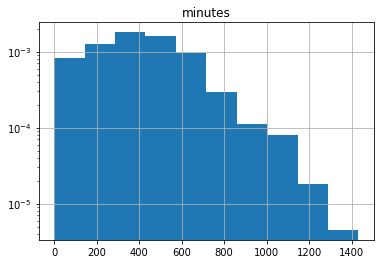

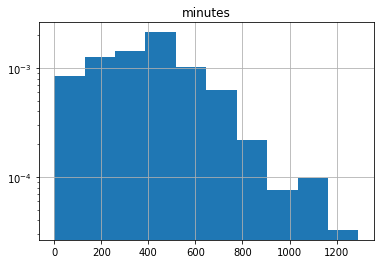

In [155]:
data_surf.hist('minutes', log=True, density= True)
data_ultimate.hist('minutes', log=True, density=True)

In [156]:
minutes_per_month = 1200/12
minutes_per_month

100.0

In [157]:
data_surf.groupby('month')['minutes'].mean()

month
1.0     193.000000
2.0     281.333333
3.0     311.434783
4.0     332.920000
5.0     377.532468
6.0     407.690722
7.0     425.000000
8.0     387.660494
9.0     391.453608
10.0    405.304721
11.0    401.304348
12.0    449.684211
Name: minutes, dtype: float64

In [158]:
data_ultimate.groupby('month')['minutes'].mean()

month
1.0     183.750000
2.0     380.428571
3.0     286.166667
4.0     317.095238
5.0     384.206897
6.0     350.361702
7.0     404.271186
8.0     394.085714
9.0     416.571429
10.0    426.295238
11.0    423.403226
12.0    431.239726
Name: minutes, dtype: float64

### Conclusion for minutes

There are more calls and minutes in the Surf plan than in the Ultimate plan. Surf has more than double the customers 333 to Surf and 157 to Ultimate in the data. So that makes sense.

The data for Surf is skewed right with minutes per user having a mean of 405.25, a dispersion of 49112.75, and a std of 221.68

The data for Ultimate is skewed to the right with minutes per user having a mean of 406.70, a disperison of 51579.92, and a std of 227.27 

Even though there are more users for Surf the average, dispersion, and std are similar for both plans. Probably because the Ultimate users have more minutes to use in their plan before they get charged more even though there are less customers.

I believe that both plans would need about 100 minutes per month for users

1. Yes I was reffering to total minutes used by all users. Is that not a useful metric?
2. I divided by number of months. But now I used a different method and found a difference
3. I took the 405 and 407 average from the describe method but I see that I could have found the average a different way for each month.

##### So it seems to me from the data above that Surf and Ultimate have very similar averages per month for minutes. The first month starts low and then it rises. The largest amount of minutes per month is for Surf 447 and for Ultimate 431 in the 12th month. The numbers look very similar to me.

In [159]:
print(data_surf['messages'].describe())
print(data_ultimate['messages'].describe())

count    1548.000000
mean       31.111757
std        33.641112
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages, dtype: float64
count    708.000000
mean      37.798023
std       34.896049
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages, dtype: float64


In [160]:
variance_surf_messages = np.var(data_surf['messages'])
variance_surf_messages

1130.9933243027597

In [161]:
variance_ultimate_messages = np.var(data_ultimate['messages'])
variance_ultimate_messages

1216.0142898751956

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8323e2c350>]],
      dtype=object)

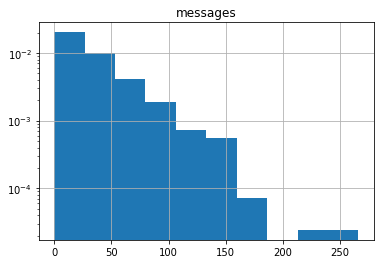

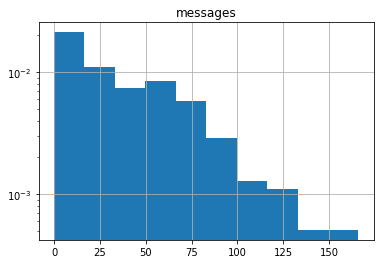

In [162]:
data_surf.hist('messages', log=True, density= True)
data_ultimate.hist('messages', log=True, density=True)

In [163]:
messages_per_month = 200/12
messages_per_month

16.666666666666668

In [164]:
data_surf.groupby('month')['messages'].mean()

month
1.0     10.500000
2.0     12.000000
3.0     15.260870
4.0     17.400000
5.0     24.012987
6.0     25.298969
7.0     27.033058
8.0     28.777778
9.0     30.762887
10.0    33.682403
11.0    32.583333
12.0    38.703947
Name: messages, dtype: float64

In [165]:
data_ultimate.groupby('month')['messages'].mean()

month
1.0     15.500000
2.0     21.571429
3.0     20.250000
4.0     22.047619
5.0     32.103448
6.0     29.340426
7.0     32.830508
8.0     38.814286
9.0     38.380952
10.0    39.428571
11.0    39.209677
12.0    45.561644
Name: messages, dtype: float64

### Conclusion for messages

There are more messages in the Surf plan than in the Ultimate plan. Surf has more than double the customers 333 to Surf and 157 to Ultimate in the data. So that makes sense.

The data for Surf is skewed right with messages per user having a mean of 31.15, a dispersion of 1126, and a std of 33.57

The data for Ultimate is skewed to the right with messages per user having a mean of 37.55, a disperison of 1207, and a std of 34.77 

Here also even though there are more users for Surf the average, dispersion, and std are similar for both plans. Probably because the Ultimate users have more messages to use in their plan before they get charged more even though there are less customers.

I believe for both plans the users would need about 16 messages per month

1. I was talking about total messages...but I realize that it may not be the best metric since There are more surf customers than Ultimate customers.
2. I also divided total by month here but seems it is not the best way.

##### So I calculated again by groupby and again found very close call between Surf and Ultimate. The largest amount of messages on average sent in Ultimate was 45 in month 12 and for Surf 38 in month 12. They both started low in January and continued on an upward trend towards December.

In [166]:
print(data_surf['internet'].describe())
print(data_ultimate['internet'].describe())

count     1548.000000
mean     16560.804910
std       8006.517664
min          0.000000
25%      12041.500000
50%      16832.000000
75%      20992.750000
max      70932.000000
Name: internet, dtype: float64
count      708.000000
mean     17242.920904
std       7883.445608
min          0.000000
25%      12671.750000
50%      16859.000000
75%      21096.250000
max      46596.000000
Name: internet, dtype: float64


In [168]:
variance_surf_internet = np.var(data_surf['internet'])
variance_surf_internet

64062914.047211036

In [169]:
variance_ultimate_internet = np.var(data_ultimate['internet'])
variance_ultimate_internet

62060933.98526923

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83294f7350>]],
      dtype=object)

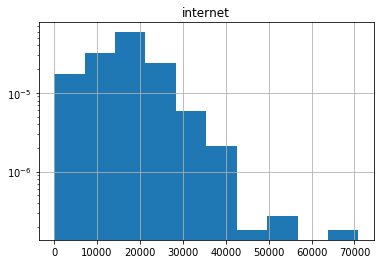

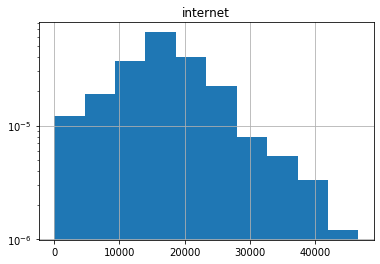

In [170]:
data_surf.hist('internet', log=True, density= True)
data_ultimate.hist('internet', log=True, density=True)

In [171]:
data_per_month = 21000/12
data_per_month

1750.0

In [172]:
data_surf.groupby('month')['internet'].mean()

month
1.0      4875.000000
2.0     12179.444444
3.0     13345.956522
4.0     11984.660000
5.0     13936.857143
6.0     15302.000000
7.0     16784.090909
8.0     16795.820988
9.0     16591.917526
10.0    17319.798283
11.0    16375.706522
12.0    18181.911184
Name: internet, dtype: float64

In [173]:
data_ultimate.groupby('month')['internet'].mean()

month
1.0      6918.500000
2.0     17129.142857
3.0     18322.083333
4.0     16122.190476
5.0     16624.965517
6.0     15338.425532
7.0     16345.288136
8.0     17810.042857
9.0     17156.226190
10.0    17618.971429
11.0    17129.604839
12.0    18306.082192
Name: internet, dtype: float64

### Conclusion for Internet

There is more internet being used in the Surf plan than in the Ultimate plan. Surf has more than double the customers 333 to Surf and 157 to Ultimate in the data. So that makes sense. But here it seems the usage is pretty much the same except for some outlier at around 70000

The data for Surf is skewed right with internet usage per user having a mean of 16558.78, a dispersion of 64175621, and a std of 8013.52

The data for Ultimate is almost normal distribution but still skews to the right a bit with internet usage per user having a mean of 17215, a disperison of 61566495.66, and a std of 7851.89 

Here again the data is close but not as close because of the outliers in Surf.

For both plans the users would need about 1750 volume ofdata per month

1. I was talking about total internet use...but I realize that it may not be the best metric since There are more surf customers than Ultimate customers.
2. I also divided total by month here but seems it is not the best way.

##### So I calculated again by groupby and again found very close call between Surf and Ultimate. The largest amount of internet usage on average used in Ultimate was 18306 in month 12 and for Surf 18181 in month 12. They both started low in January and continued on an upward trend towards December. Surf took some time catching up in the beginning months but eventually they both were averaging about the same data usage towards the later months

## Step 4. Test the hypotheses

The average profit from users of Ultimate and Surf calling plans differs.

The average profit from users in NY-NJ area is different from that of the users from other regions.

You decide what alpha value to use.

Explain:
How you formulated the null and alternative hypotheses.
What criterion you used to test the hypotheses and why.

In [174]:
print(data_surf['profit'].mean()) 
print(data_ultimate['profit'].mean())

60.27624031007752
72.35310734463278


In [175]:
ny_nj_users = data_for_profit_clean.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')

In [176]:
not_nynj_users = data_for_profit_clean.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')

In [177]:
print(ny_nj_users['profit'].mean()) 
print(not_nynj_users['profit'].mean())

59.621401617250676
64.94115649867373


### Created two separate tables. One with NY and NJ users and one without NY and NJ users

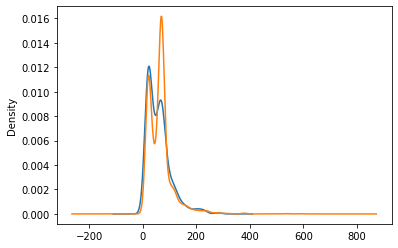

In [178]:
ny_nj_users['profit'].plot(kind='density')
not_nynj_users['profit'].plot(kind='density')

In [179]:
data_surf.groupby('month')['profit'].mean()

month
1.0     20.000000
2.0     34.260000
3.0     45.792609
4.0     40.458600
5.0     47.240130
6.0     48.935155
7.0     62.226529
8.0     63.576728
9.0     57.952320
10.0    65.206652
11.0    57.827174
12.0    69.979868
Name: profit, dtype: float64

In [180]:
data_ultimate.groupby('month')['profit'].mean()

month
1.0     70.000000
2.0     70.000000
3.0     74.666667
4.0     73.000000
5.0     70.724138
6.0     71.638298
7.0     71.898305
8.0     72.900000
9.0     72.083333
10.0    72.333333
11.0    71.750000
12.0    73.404110
Name: profit, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8323bac190>]],
      dtype=object)

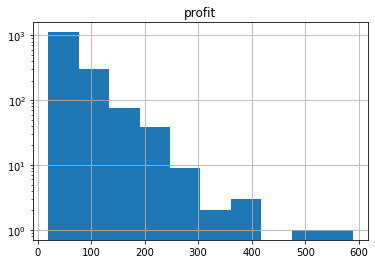

In [181]:
data_surf.hist('profit', log=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8323a04e10>]],
      dtype=object)

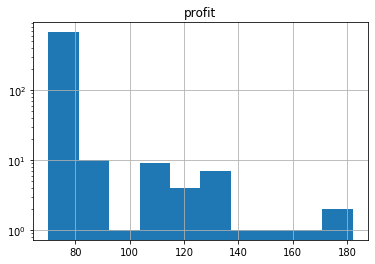

In [182]:
data_ultimate.hist('profit', log=True)

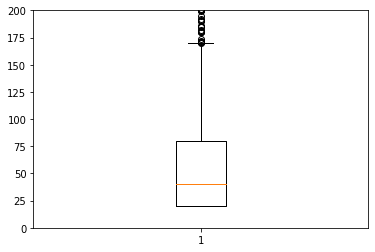

In [183]:
plt.boxplot(data_surf['profit'])
plt.ylim(0, 200)
plt.show()

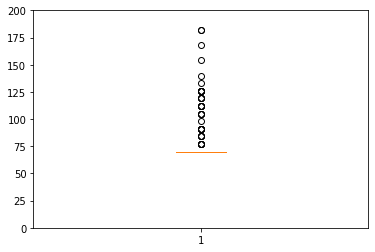

In [184]:
plt.boxplot(data_ultimate['profit'])
plt.ylim(0,200)
plt.show()

In [185]:
print(data_ultimate['profit'].describe())

count    708.000000
mean      72.353107
std       11.487385
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: profit, dtype: float64


Here most of the data falls within 70 dollars. So I will take anything above 70 and make it an outlier for data_ultimate

In [186]:
data_surf[ 'profit'].describe()

count    1548.000000
mean       60.276240
std        55.228362
min        20.000000
25%        20.000000
50%        40.255000
75%        80.000000
max       588.660000
Name: profit, dtype: float64

Here most of the data falls below 200 and there are some huge outliers in the 500s or so. I will make my outliers below 200 then.

In [187]:
data_surf_new = data_surf[data_surf['profit'] < 180]

In [188]:
data_ultimate_new = data_ultimate[data_ultimate['profit'] <= 70]

Took away the outliers

In [189]:
data_ultimate_new['profit'].describe()

count    667.0
mean      70.0
std        0.0
min       70.0
25%       70.0
50%       70.0
75%       70.0
max       70.0
Name: profit, dtype: float64

In [190]:
data_surf_new['profit'].describe()

count    1484.000000
mean       52.420849
std        38.122761
min        20.000000
25%        20.000000
50%        40.000000
75%        80.000000
max       179.810000
Name: profit, dtype: float64

While Ultimate stays the same in its description theres a significant jump in Surf data in the description.

Looks like the variance is not the same

In [191]:
data_ultimate_new['profit'].sum()

46690.0

In [192]:
data_surf_new['profit'].sum()

77792.54000000001

Surf makes more profit based on number of users but the average profit is better for Ultimate plan

Surfs average profit is 52 while Ultimates average profit is 70

In [193]:
data_surf_new['profit'].var()

1453.3448826231886

In [194]:
data_ultimate['profit'].var()

131.9600044750238

Definitely have a different variance in the two datasets. Ttest won't be so helpful here. It is normally used for normally distributed data but as we saw Ultimate and Surf are both right skewed.

### Conclusion

There is more profit coming from the not_nynj_users and from the Surf plan in general

In [195]:
# Testing hypothesis of: The average profit from users of Ultimate and Surf calling plans differs

#data_surf_sample = data_surf['profit'].sample(10)
#data_ultimate_sample = data_ultimate['profit'].sample(10)
list_surf = data_surf_new['profit']
list_ultimate = data_ultimate_new['profit']

alpha = 0.05 

#results = st.ttest_ind(data_surf_sample, data_ultimate_sample)
results = st.ttest_ind(data_surf_new['profit'], data_ultimate_new['profit'])

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  1.0496426908529223e-31
We reject the null hypothesis


### Conclusion

The average profit from users of Ultimate and Surf calling plans does differ according to the fact that we can't reject the null hypothesis. The alternative hypothesis is that they don't differ. This is most probably the case based on the fact that we have more Surf customers than the plan for Ultimate but if Ultimate had the same number of customers the average profit would look similar. We are using a small sample here and what is interesting is when I used the complete data the null hypothesis was rejected. This may not be the best test for finding out the difference of the plans  

### New Conclusion

The average profit from the users Ultimate and Surf calling plans doesn't differ according to the fact that we reject the null hypothesis. The alternative hypothesis is that they do differ. 

In [196]:
# The average profit from users in NY-NJ area is different from that of the users from other regions.

list_nynj = ny_nj_users['profit']
list_not_nynj = not_nynj_users['profit']

#ny_nj_users_sample = ny_nj_users['profit'].sample(10)
#not_nynj_users_sample = not_nynj_users['profit'].sample(10)

alpha = .05 

#results = st.ttest_ind(ny_nj_users_sample, not_nynj_users_sample)
results = st.ttest_ind(list_nynj, list_not_nynj)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  0.044108814472504344
We reject the null hypothesis


### New Conclusion

The average profit from users in NY-NJ area does not differ from that of the users from other regions based on teh fact that we reject the null hypothesis. The alternative hypothesis is that they will differ.

## Step 5. Overall New Conclusion

After finding a few errors in the data at the beginning of the project and weening them out and calculating the profits (getting rid of users that had gotten caught with charges after they terminated the plan still kept the data similar)

Seems that Surf has better total profit with this data but more customers. The Ultimate plan averages a better profit by 18. We tested the hypothesis even though it is not the best to use. First of all because the variance of the data is different. But in our results we find that we reject the null hypothesis and therefore the Ultimate Plan and Surf Plan average profit are similar and so is the average profit for NYNJ users and Non_NYNJ users. However again this isn't the best test to use but it is the test that we learned so far.

### Project completion checklist

Mark the completed tasks with 'x'. Then press Shift+Enter.

- [x]  file opened
- [x]  files explored (first rows printed, info() method)
- [x]  missing values determined
- [x]  missing values filled in
- [x]  clarification of the discovered missing values provided
- [x]  data types converted
- [x]  explanation of which columns had the data types changed and why
- [x]  calculated and added to the table: The number of calls made and minutes used per month
- [x]  calculated and added to the table: The number of text messages sent per month
- [x]  calculated and added to the table: The monthly profit from each user (subtract the free package limit from the total number of calls, text messages, and data; multiply the result by the calling plan value; add the monthly charge depending on the calling plan)
- [x]  the following parameters investigated: minutes, texts, volume of data of each plan required per month
- [x]  histograms for each parameter created
- [x] Described distributions
- [x] Test Hypotheses: The average profit from users of Ultimate and Surf calling plans differs
- [x] Test Hypotheses: The average profit from users in NY-NJ area is different from that of the users from other regions
- [x] Explanation of null and alternative hypotheses
- [x]  each stage has a conclusion
- [x]  overall conclusion drawn